## Genetic Algorithm for hyperparams optimization

Использование генетического алгоритма для оптимизации гиперпараметров модели XGBoost. XGBoost. 

Инициализация параметров генетического алгоритма: случайно при создании популяции.

Search параметров [XGBoost](https://xgboost.readthedocs.io/en/latest/parameter.html):
* max_depth - максимальная глубина отдельного дерева;
* min_child_weight - минимальная сумма весов объектов, необходимая для разбиения дерева;
* subsample - доля объектов, которая будет использована для обучения отдельного дерева;
* colsample_bytree - доля признаков, которая используется для построения каждого отдельного дерева;
* gamma - минимальное значение функции потерь, при котором возможно разбиение в вершине дерева.



In [1]:
from typing import Dict
from copy import deepcopy
from tqdm import tqdm

import random
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("train.csv")
data = data.sample(50000).reset_index(drop=True)

data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,COMMUNICATION_TYPE
0,306720,0,Cash loans,M,Y,N,3,360000.0,962370.0,77161.5,...,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0,PUSH
1,359870,0,Cash loans,F,N,Y,0,112500.0,254700.0,17149.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0,SMS
2,282524,0,Cash loans,M,N,Y,0,180000.0,229500.0,13995.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,SMS
3,326154,0,Cash loans,F,N,N,0,112500.0,454500.0,21996.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,PUSH
4,286487,0,Cash loans,F,N,Y,1,135000.0,171000.0,13639.5,...,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0,SMS


In [3]:
x_train, x_valid = train_test_split(
    data, train_size=15000, random_state=1
)
x_train = x_train.reset_index(drop=True)
x_valud = x_valid.reset_index(drop=True)

y_train, y_valid = x_train["TARGET"], x_valid["TARGET"]

In [4]:
def init_population(number_of_parents: int) -> Dict[str, np.array]:
    """
    Инициализация начальной популяции генетического алгоритма.

    Parameters
    ----------
    number_of_parents: int
        Количество родителей в популяции.

    Returns
    -------
    population: dict, Dict[str, np.array]
        Словарь с начальной популяцией.

    """
    population = {
        "max_depth": np.empty([number_of_parents, 1], dtype=np.uint8),
        "min_child_weight": np.empty([number_of_parents, 1], dtype=np.uint8),
        "subsample": np.empty([number_of_parents, 1]),
        "colsample_bytree": np.empty([number_of_parents, 1]),
        "gamma": np.empty([number_of_parents, 1])
    }

    for i in range(number_of_parents):
        population["max_depth"][i] = round(
            random.randrange(1, 10, step=1)
        )
        population["min_child_weight"][i] = round(
            random.uniform(0.01, 10), 2
        )
        population["subsample"][i] = round(
            random.uniform(0.01, 1), 2
        )
        population["colsample_bytree"][i] = round(
            random.uniform(0.01, 1), 2
        )
        population["gamma"][i] = round(
            random.uniform(0.01, 10), 2
        )
    return population

Ограничения на значения параметры наложены из рекомендаций документации XGBoost, либо на основании разумных предположений о возможном значении параметров.

## Селеция или отбор родителей


In [5]:
def train_population(population,
                     xgb_train: xgb.DMatrix,
                     xgb_valid: xgb.DMatrix,
                     y_valid: pd.Series
                     ):
    """
    Обучение модели на каждом значении population.
    После обучения модели, производится оценка качества
    модели с помощью метрики ROC-AUC на данных xgb_valid.

    Parameters
    ----------
    population: numpy.array
        Матрица с текущим значением популяции.

    xgb_train: xgb.DMatrix
        Выборка для обучения модели, в формате xgboost.DMatrix.

    xgb_valid: xgb.DMatrix
        Выборка для тестирования модели, в формате xgboost.DMatrix.

    y_valid: pd.Series
        Значение целевой переменной для тестирования модели.

    Returns
    -------
    scores: List[float]
        Список со значеним метрик качества.

    """
    scores = []
    for i in range(population.shape[0]):
        xgb_params = {
            "booster": "gbtree",
            "objective": "binary:logistic",
            "learning_rate": 0.1,
            "max_depth": int(population[i][0]),
            "min_child_weight": population[i][1],
            "subsample": population[i][2],
            "colsample_bytree": population[i][3],
            "gamma": population[i][4],
            "eval_metric": "auc",
            "nthread": 6,
            "seed": 27
        }
        model = xgb.train(
            params=xgb_params,
            dtrain=xgb_train,
            evals=[(xgb_train, "train"), (xgb_valid, "valid")],
            early_stopping_rounds=50,
            num_boost_round=1000,
            verbose_eval=25,
        )
        y_pred = model.predict(xgb_valid)
        score = roc_auc_score(y_valid, y_pred)
        scores.append(score)
        print("="*84)

    return scores

In [6]:
num_features = x_train.select_dtypes(exclude=["object"]).columns
x_train, x_valid = x_train[num_features], x_valid[num_features]

to_drop = ["SK_ID_CURR", "TARGET"]
x_train = x_train.drop(to_drop, axis=1)
x_valid = x_valid.drop(to_drop, axis=1)

In [7]:
xgb_train = xgb.DMatrix(
    data=x_train, label=y_train
)
xgb_valid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

Определим, сколько родителей мы хотели бы выбрать, и создадим массив с выбранными родителями, основываясь на значениях метрики качества.

In [8]:
def select_new_parents(population: np.array, scores: list, num_parents: int):
    """
    Выбор оптимальный параметров популяции на основе
    значений метрики качества ROC-AUC.

    Parameters
    ----------
    population: np.array
        Матрица с текущим значением популяции.

    scores: List[float]
        Список со значениями метрики качества.

    num_parents: int
        Количество родителей, которые требуется отобрать.

    Returns
    -------
    selected_parents: np.array
        Значение популяции, отобранное на основе метрики качества.

    """
    scores = deepcopy(scores)
    selected_parents = np.empty((
        num_parents, population.shape[1]
    ))

    for parent_id in range(num_parents):
        best_result_id = np.where(scores == np.max(scores))
        best_result_id = best_result_id[0][0]

        selected_parents[parent_id, :] = population[best_result_id, :]
        scores[best_result_id] = -1

    return selected_parents

## Crossovers


In [79]:
def get_split_pts(array, n_pts):
    
    """Returns sorted indices for slicing """
    
    res = []
    for i in range(n_pts):
        l = len(array)
        p = random.randint(0, l-1) # choose random item index
        s = array.pop(p) # exclude this point
        res.append(s)
    res.sort()  
    
    return np.array(res)
    

def crossover_ur(parents, children_size, pts=3):
    
    """
    Include Multi-Point Crossover. Accepts ANY number of splits.
    Returns resulted genetic childs
    """
    
    assert pts <= parents.shape[1]
            
    # Multi-Point Point Crossover routine
        
    # parents indices
    idx_1 =  np.arange(0, np.uint8(children_size[1]), 1, dtype=np.uint8)   

    split_idx = get_split_pts(list(idx_1), pts) # array with split points idx

    children = np.zeros(children_size)

    # get taken indices for each parent
    idx_2 = []
    idx_3 = []
    t = 0 # tmp current lower element index for iterations
    for i in range(len(split_idx)+1):
        # even/odd filter
        if i%2==0:
            if i == len(split_idx):
                [idx_2.append(x) for x in idx_1[t:]]
            else:
                [idx_2.append(x) for x in idx_1[t:split_idx[i]]]
                t = split_idx[i]
        else:
            if i == len(split_idx):
                [idx_3.append(x) for x in idx_1[t:]]
            else:
                [idx_3.append(x) for x in idx_1[t:split_idx[i]]]
                t = split_idx[i]

    print(f"SPLIT POINTS: {split_idx}")
    print(f"TAKE IDX FROM PARENT 1: {idx_2}")
    print(f"TAKE IDX FROM PARENT 2: {idx_3}")
    
    # Generate childs for consequent parents pairs by chosen split
    for i in range(children_size[0]):
        parent1_idx = i % parents.shape[0]
        parent2_idx = (i+1) % parents.shape[0]
        children[i, idx_2] = parents[parent1_idx, idx_2]
        children[i, idx_3] = parents[parent2_idx, idx_3]
            
    return children


In [80]:
#################
# TEST ROUTINE
#################

# visualize crossovers work
test_parents = np.array([[i]*10 for i in range(2)])
children_size = test_parents.shape

print(f"Initial state: \n {test_parents}")
print('='*40)

splits = np.arange(1, 11) # [1,2,3,4,5,6,7,8,9,10]
for split in splits:
    print(f"NUM SPLITS: {split}")
    r = crossover_ur(test_parents, children_size, pts=split)
    print(f"\nResulted children: \n {r}\n")
    print('='*40 + '\n')

Initial state: 
 [[0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]]
NUM SPLITS: 1
SPLIT POINTS: [6]
TAKE IDX FROM PARENT 1: [0, 1, 2, 3, 4, 5]
TAKE IDX FROM PARENT 2: [6, 7, 8, 9]

Resulted children: 
 [[0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]]


NUM SPLITS: 2
SPLIT POINTS: [3 6]
TAKE IDX FROM PARENT 1: [0, 1, 2, 6, 7, 8, 9]
TAKE IDX FROM PARENT 2: [3, 4, 5]

Resulted children: 
 [[0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1. 1. 1. 1.]]


NUM SPLITS: 3
SPLIT POINTS: [3 4 8]
TAKE IDX FROM PARENT 1: [0, 1, 2, 4, 5, 6, 7]
TAKE IDX FROM PARENT 2: [3, 8, 9]

Resulted children: 
 [[0. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 0. 0.]]


NUM SPLITS: 4
SPLIT POINTS: [1 5 6 7]
TAKE IDX FROM PARENT 1: [0, 5, 7, 8, 9]
TAKE IDX FROM PARENT 2: [1, 2, 3, 4, 6]

Resulted children: 
 [[0. 1. 1. 1. 1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 1. 1.]]


NUM SPLITS: 5
SPLIT POINTS: [0 1 6 7 9]
TAKE IDX FROM PARENT 1: [1, 2, 3, 4, 5, 7, 8]
TAKE IDX FROM PARENT 2: [0

## Мутация


In [21]:
def mutation(crossover, number_of_parameters):
    """
    Мутация объектов популяции, получение новых значений
    гиперпараметров для проверки гипотезы о повышении качества
    работы модели.

    Parameters
    ----------
    crossover: np.array
        Исходные объекты популяции.

    number_of_parameters: int
        Количество параметров.

    Returns
    -------
    crossover: np.array
        Мутированные объекты популяции.

    """
    min_max_values = np.zeros((number_of_parameters, 2))

    min_max_values[0, :] = [1, 15] # ограничение для max_depth
    min_max_values[1, :] = [0, 10] # ограничение для min_child_weight
    min_max_values[2, :] = [0.01, 1] # ограничение для subsample
    min_max_values[3, :] = [0.01, 1] # ограничение для colsample_bytree
    min_max_values[4, :] = [0.01, 10] # ограничение для gamma
    parameter_selected = np.random.randint(0, 5, 1)

    if parameter_selected == 0:
        mutation_value = np.random.randint(-5, 5, 1)
    elif parameter_selected == 1:
        mutation_value = round(np.random.uniform(5, 5), 2)
    elif parameter_selected == 2:
        mutation_value = round(np.random.uniform(-0.5, 0.5), 2)
    elif parameter_selected == 3:
        mutation_value = round(np.random.uniform(-0.5, 0.5), 2)
    elif parameter_selected == 4:
        mutation_value = round(np.random.uniform(-2, 2), 2)

    for idx in range(crossover.shape[0]):
        crossover[idx, parameter_selected] = crossover[idx, parameter_selected] + mutation_value
        if crossover[idx, parameter_selected] > min_max_values[parameter_selected, 1]:
            crossover[idx, parameter_selected] = min_max_values[parameter_selected, 1]
        else:
            crossover[idx, parameter_selected] = min_max_values[parameter_selected, 0]

    return crossover

## Вычислительный эксперимент

In [22]:
number_of_parents = 8
number_of_parents_mating = 4
number_of_parameters = 5
number_of_generation = 6

population_size = (number_of_parents, number_of_parameters)
scores_history = np.empty([number_of_generation+1, number_of_parents])

params_history = np.empty([(number_of_generation+1) * number_of_parents, number_of_parameters])

In [23]:
population = init_population(number_of_parents)

population = np.concatenate((
    population["max_depth"],
    population["min_child_weight"],
    population["subsample"],
    population["colsample_bytree"],
    population["gamma"]), axis=1)

params_history[0:number_of_parents, :] = population

In [24]:
for generation in tqdm(range(number_of_generation)):
    best_score, mean_score = np.max(scores_history), np.mean(scores_history)
    print(f"All-history: Best ROC-AUC = {round(best_score, 4)}, Mean ROC-AUC = {round(mean_score, 4)}")

    scores = train_population(
        population=population,
        xgb_train=xgb_train,
        xgb_valid=xgb_valid,
       y_valid=y_valid)

    scores_history[generation, :] = scores

    parents = select_new_parents(
        population=population,
        scores=scores,
        num_parents=4)

    children = crossover_ur(
        parents=parents,
        children_size=(population_size[0] - parents.shape[0], 5)
    )
    children_mutated = mutation(children, number_of_parameters=5)
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]:, :] = children_mutated

    params_history[(generation+1)*8 : (generation+1)*8+8 , :] = population
    clear_output()

scores_history = pd.DataFrame(scores_history)
scores_history = scores_history.loc[:5]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:15<00:00, 32.62s/it]


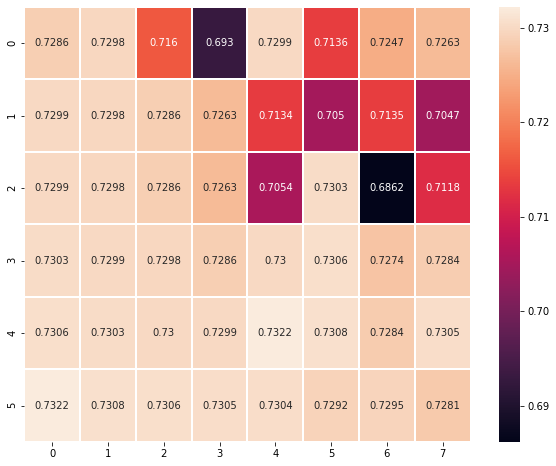

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(scores_history, annot=True, fmt='.4g', linewidths=1, ax=axes)